# COVID-19 Headlines

[The anonymous web service Top.st](top.st) extracts the contemporary most-shared news. The [social-bot Topstbot](https://botsin.space/topst) promotes the top most headline on the [federated social-media platform Mastodon](https://mastodon.io). Assuming, its feed can be regarded as an archive of top relevant news headlines, how did German media react to the COVID-19 numbers?

In [1]:
from scrape import entorb

cases = entorb.to_dataframe('DE-total')

In [2]:
cases_new = cases['Cases_New']
high_cases_new = cases_new[(cases_new.shift(1) < cases_new) & (cases_new.shift(-1) < cases_new)]
low_cases_new = cases_new[(cases_new.shift(1) > cases_new) & (cases_new.shift(-1) > cases_new)]

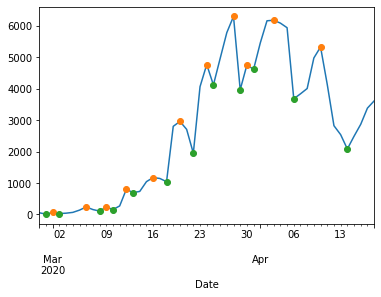

In [3]:
import matplotlib.pyplot as plt
cases_new.plot(kind='line')
high_cases_new.plot(kind='line', linestyle='', marker='o')
low_cases_new.plot(kind='line', linestyle='', marker='o')

In [4]:
#!pip install tabulate
import pandas as pd
from lxml.html.soupparser import fromstring
from scrape import topstbot

nation = 'de'
headlines = topstbot.to_dataframe(since='2020-03-01T00:00:00.000Z', tagged=['day', nation])

headlines['content'] = [fromstring(h).text_content() for h in headlines['content']]
headlines['date'] = headlines.index.normalize().tz_localize(None)
headlines['text'] = [x.split("\t")[0] for x in headlines['content']]
headlines['url'] = [x.split("\t")[1].replace('#news #day #de', '') for x in headlines['content']]
headlines = headlines \
.reset_index() \
.drop(columns=['content', 'url']) \
.set_index('date')

In [5]:
# high cases
pd.set_option('display.max_colwidth', 100)
display(headlines \
        .loc[headlines.index.intersection(high_cases_new.index).drop_duplicates()] \
        .set_index('created_at'))

,text
created_at,
2020-04-10 18:00:08.686000+00:00,"Diesel Fahrverbote - Kaum Verkehr, trotzdem Grenzwert-Überschreitung: Corona entlarvt Fahrverbot..."
2020-04-10 06:00:09.151000+00:00,"Besuche, Ausflüge, Ostereier-Suche - Was darf ich an Ostern überhaupt? Die große Corona-Regeln-Ü..."
2020-04-03 18:00:08.162000+00:00,"Coronavirus in Deutschland – über 1.000 Tote, 81.700 Infizierte"
2020-04-03 06:00:09.245000+00:00,Kamera filmt Herzlos-Herrchen - Armen Hund einfach am Tierheim angebunden
2020-03-30 18:00:08.574000+00:00,Coronavirus in Deutschland: Mehr als 62.000 Infizierte – Live-Karte
2020-03-30 06:00:12.335000+00:00,Coronavirus in Deutschland: Gut 58.000 Infizierte – Live-Karte
2020-03-28 19:00:07.744000+00:00,"Krankenschwester: ""Ich will nicht infiziert sein und arbeiten müssen"""
2020-03-28 07:00:06.280000+00:00,Corona-Krise: Bundeswehr mobilisiert 15.000 Soldaten
2020-03-24 19:00:08.779000+00:00,Entschädigung bei Verdienstausfall: Staat zahlt bis zu 2016 Euro bei Kitaschließung


In [6]:
# low cases
pd.set_option('display.max_colwidth', 100)
display(headlines \
        .loc[headlines.index.intersection(low_cases_new.index).drop_duplicates()] \
        .set_index('created_at'))

,text
created_at,
2020-04-14 18:00:15.545000+00:00,Person der Woche: Zheng-Li Shi: Hat China Angst vor der Wahrheit?
2020-04-14 06:00:07.753000+00:00,Leopoldina-Forscher legen konkreten Fahrplan für Ende der Kontaktsperren vor
2020-04-06 18:00:08.269000+00:00,Polizei-fahndung - Räuber-Duo überfällt Frau im Schlaf
2020-04-06 06:00:08.421000+00:00,Grenzschließung gilt für alle - nur nicht für Asylbewerber
2020-03-31 18:00:08.364000+00:00,USA melden doppelt so viele Infektionen wie China
2020-03-31 06:00:06.405000+00:00,Bericht: BKA stuft Anschlag in Hanau nicht als rechtsextremistische Tat ein
2020-03-29 18:00:08.400000+00:00,Hessischer Finanzminister Schäfer ist tot
2020-03-29 06:00:05.215000+00:00,Luftwaffe fliegt an Covid-19 erkrankte Italiener nach Deutschland
2020-03-25 19:00:09.093000+00:00,Coronavirus-Livekarte Deutschland: Über 34.000 Covid-19-Infizierte


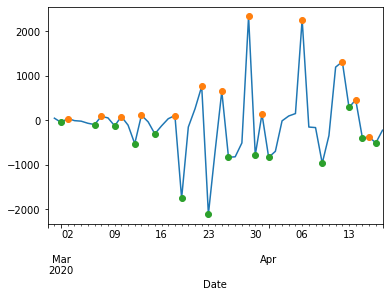

In [7]:
# change over time and its peaks
ts = (cases_new.shift(1)-cases_new)
ts.plot()
max_ts = ts[(ts.shift(1) < ts) & (ts.shift(-1) < ts)]
max_ts.plot(kind='line', linestyle='', marker='o')
min_ts = ts[(ts.shift(1) > ts) & (ts.shift(-1) > ts)]
min_ts.plot(kind='line', linestyle='', marker='o')

In [8]:
display(headlines \
        .loc[headlines.index.intersection(max_ts.index).drop_duplicates()] \
        .set_index('created_at'))

,text
created_at,
2020-04-16 18:00:12.596000+00:00,China unter Verdacht - Kam das Virus aus dem Labor von Wuhan?
2020-04-16 06:00:06.226000+00:00,Tierpark bereitet sich auf Notschlachtung vor
2020-04-14 18:00:15.545000+00:00,Person der Woche: Zheng-Li Shi: Hat China Angst vor der Wahrheit?
2020-04-14 06:00:07.753000+00:00,Leopoldina-Forscher legen konkreten Fahrplan für Ende der Kontaktsperren vor
2020-04-12 18:00:07.260000+00:00,Mehr Genesene als Infizierte in Deutschland
2020-04-12 06:00:05.612000+00:00,"Stangen, latten, Steine - Schock-Angriff auf Corona-Streife"
2020-04-06 18:00:08.269000+00:00,Polizei-fahndung - Räuber-Duo überfällt Frau im Schlaf
2020-04-06 06:00:08.421000+00:00,Grenzschließung gilt für alle - nur nicht für Asylbewerber
2020-03-31 18:00:08.364000+00:00,USA melden doppelt so viele Infektionen wie China


In [9]:
display(headlines \
        .loc[headlines.index.intersection(min_ts.index).drop_duplicates()] \
        .set_index('created_at'))

,text
created_at,
2020-04-17 18:00:08.907000+00:00,Wolfgang Schäuble will wegen Corona Sommerferien verkürzen
2020-04-17 06:00:06.732000+00:00,Trotz Sozialleistungen: Hassprediger zockte 18 000 Euro-Corona-Hilfe ab
2020-04-15 18:00:06.577000+00:00,Warum Deutschlands Lockdown falsch ist – und Schweden vieles besser macht
2020-04-15 06:00:11.055000+00:00,Youtube-Star JayJay Jackpot mit 32 Jahren gestorben!
2020-04-13 18:00:08.128000+00:00,Leopoldina-Forscher legen konkreten Fahrplan für Ende der Kontaktsperren vor
2020-04-13 06:00:07.260000+00:00,Mehr Genesene als Infizierte in Deutschland
2020-04-09 18:00:11.736000+00:00,Flüchtlinge: Politik des kalten Herzens - Kommentar
2020-04-09 06:00:12.159000+00:00,Explosion auf Baustelle – Berliner Stadtschloss brennt
2020-04-01 18:00:11.909000+00:00,"Allein mit 400 Tieren - Ich weiß nicht, wie ich sie morgen noch füttern soll"


In [10]:
pd.to_datetime('2020-04-09T12:05:07 +0200')

Timestamp('2020-04-09 12:05:07+0200', tz='pytz.FixedOffset(120)')